In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [2]:
import sys
sys.path.append("../dnn_from_scratch")

In [12]:
import cifar_pre_process
dt = cifar_pre_process.CifarPreProcess()
dt.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


In [4]:
X_train=np.concatenate([dt.training_images,dt.test_images]).reshape(-1,32,32,3)*2-1

In [5]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout,conv2d,conv2dtranspose,upsampling,reshape,BatchNormalization,Activation
from nnet import functions
from nnet import optimizers
import numpy as np

Seed: 74
Seed: 926


In [14]:
def generator():
    model=Sequential()
    model.add(dense(128*8*8,activation=functions.leakyRelu,input_shape=100))
    model.add(reshape((8,8,128)))
    model.add(upsampling())
    model.add(conv2d(64,kernel_size=3,activation=functions.leakyRelu))
#     model.add(conv2dtranspose(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(upsampling())
    model.add(conv2d(32,kernel_size=3,activation=functions.leakyRelu))
#     model.add(conv2dtranspose(32,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(conv2d(3,kernel_size=3,activation=functions.tanh))
    return model
g=generator()
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 100)                echo             0
__________________________________________________________________________________________
1 dense(dense)            (None, 8192)               leakyRelu        827392
__________________________________________________________________________________________
2 reshape(reshape)        (None, 8, 8, 128)          echo             0
__________________________________________________________________________________________
3 upsampling(upsampling)  (None, 16, 16, 128)        echo             0
__________________________________________________________________________________________
4 conv2d(conv2d)          (None, 16, 16, 64)         leakyRelu        73792
__________________________________________________________________________________________
5 Batch

In [15]:
def discriminator():
    model=Sequential()
    model.add(conv2d(32,kernel_size=3,activation=functions.leakyRelu,input_shape=(32,32,3)))
    model.add(max_pool())
    model.add(BatchNormalization())
    model.add(dropout(0.25))
    model.add(conv2d(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(max_pool())
    model.add(BatchNormalization())
    model.add(dropout(0.25))
    model.add(flatten())
    model.add(dense(256,activation=functions.leakyRelu))
    model.add(dropout(0.25))
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
0 input_layer(InputLayer) (None, 32, 32, 3)          echo             0
__________________________________________________________________________________________
1 conv2d(conv2d)          (None, 32, 32, 32)         leakyRelu        896
__________________________________________________________________________________________
2 max_pool(max_pool)      (None, 16, 16, 32)         echo             0
__________________________________________________________________________________________
3 BatchNormalization(Batc (None, 16, 16, 32)         echo             128
__________________________________________________________________________________________
4 dropout(dropout)        (None, 16, 16, 32)         echo             0
__________________________________________________________________________________________
5 conv2d(con

In [16]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.002)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.002)

In [17]:
def gen_sample():
    noise=np.random.randn(64,100).astype(np.float32)
    gen=g.predict(noise)
    noise=np.random.randn(1,100).astype(np.float32)
    gen=g.predict(noise)
    plt.imshow((gen[0]+1)/2,interpolation='bicubic')
    plt.show()
    print(d.predict(gen)[0])

In [18]:
def run():
    batch_size=64
    dsz=X_train.shape[0]
    # Label real ones as 90% real
    y_fake=np.zeros((batch_size,1),dtype=np.float32)
    y_real=np.ones((batch_size,1),dtype=np.float32)
    y_gen=np.ones((batch_size,1),dtype=np.float32)
    for step in range(dsz//batch_size):
        stt=time()
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
#         X = np.concatenate([real_images,generated_images])
        # Train discriminator
        y_real=np.random.uniform(0.9,1,(batch_size,1)).astype(np.float32)
        y_fake=np.random.uniform(0,0.1,(batch_size,1)).astype(np.float32)
        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(logits=dout2,labels=y_fake).sum()
        # Treat noised input of generator as real data
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        if not step%50:
            gen_sample()
        print("\rProgress: {:.2f} %     Dloss: {}    err: {}     Sample time: {:.3f}s    _".format(step*batch_size*100/dsz,dloss,abs(err).mean(),time()-stt),end='')

EPOCH: 1 / 2


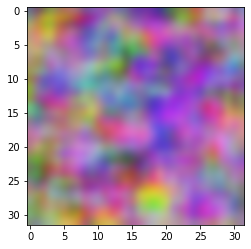

[0.5281654]
Progress: 5.23 %     Dloss: 27.078540802001953    err: 0.000357270851964131     Sample time: 1.165s    _ _

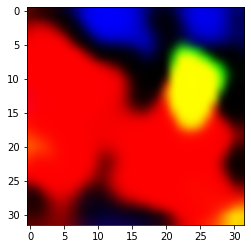

[0.9530526]
Progress: 10.56 %     Dloss: 14.298598289489746    err: 0.0013533200835809112     Sample time: 1.156s    _

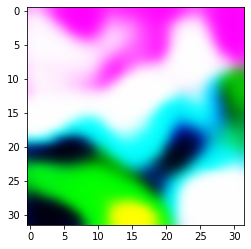

[0.03151083]
Progress: 15.89 %     Dloss: 28.186321258544922    err: 0.0026289753150194883     Sample time: 1.327s    _

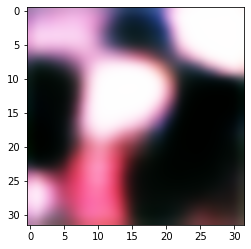

[0.215593]
Progress: 21.23 %     Dloss: 14.674386024475098    err: 0.0015144605422392488     Sample time: 1.162s    _

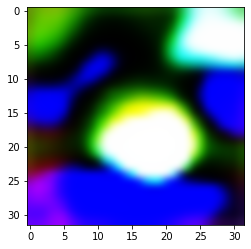

[0.00382405]
Progress: 26.56 %     Dloss: 19.524099349975586    err: 0.004008002113550901     Sample time: 2.069s    __

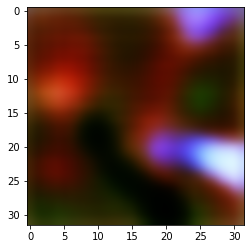

[0.00871305]
Progress: 31.89 %     Dloss: 45.749900817871094    err: 0.006794097367674112     Sample time: 1.183s    __

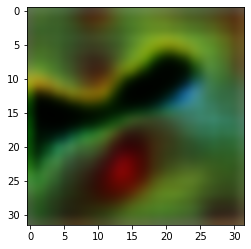

[0.36294222]
Progress: 37.23 %     Dloss: 18.86727523803711    err: 0.0021306693088263273     Sample time: 1.457s    __

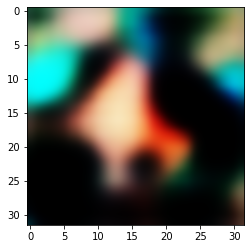

[0.00011782]
Progress: 42.56 %     Dloss: 38.50859451293945    err: 0.005653578322380781     Sample time: 1.146s    ___

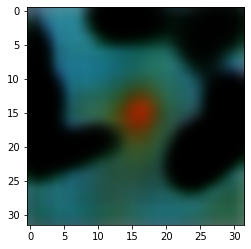

[0.22092646]
Progress: 47.89 %     Dloss: 26.349327087402344    err: 0.007594006601721048     Sample time: 1.166s    __

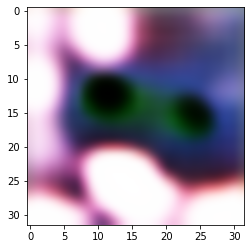

[0.13200834]
Progress: 53.23 %     Dloss: 25.444242477416992    err: 0.005340971518307924     Sample time: 1.623s    __

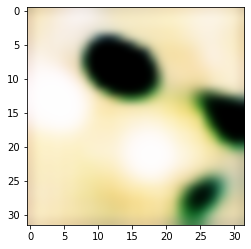

[0.6416643]
Progress: 58.56 %     Dloss: 27.080780029296875    err: 0.005327749531716108     Sample time: 1.100s    __

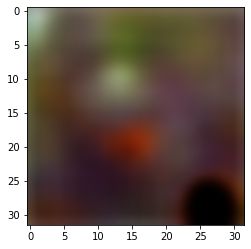

[0.31785193]
Progress: 63.89 %     Dloss: 20.393688201904297    err: 0.0038408490363508463     Sample time: 1.254s    _

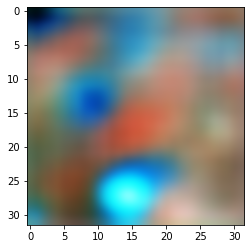

[0.01851885]
Progress: 69.23 %     Dloss: 17.192848205566406    err: 0.005395816173404455     Sample time: 1.103s    __

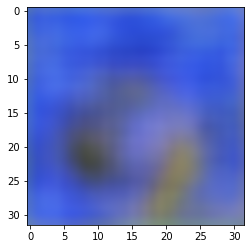

[0.06109953]
Progress: 74.56 %     Dloss: 29.553503036499023    err: 0.0069505576975643635     Sample time: 1.184s    _

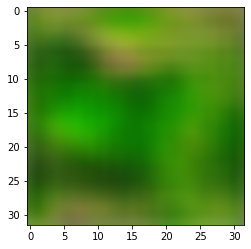

[0.00039723]
Progress: 79.89 %     Dloss: 24.351360321044922    err: 0.004433450289070606     Sample time: 1.153s    __

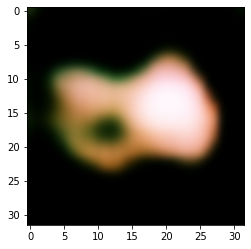

[0.01286827]
Progress: 85.23 %     Dloss: 16.07048797607422    err: 0.003343078540638089     Sample time: 1.352s    ___

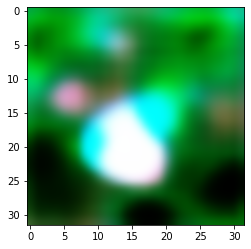

[0.01585221]
Progress: 90.56 %     Dloss: 33.10055160522461    err: 0.006529125850647688     Sample time: 1.297s    ___

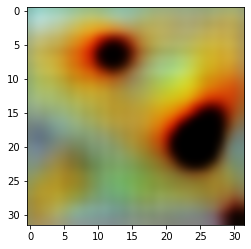

[0.6727859]
Progress: 95.89 %     Dloss: 26.328685760498047    err: 0.009229942224919796     Sample time: 1.160s    __

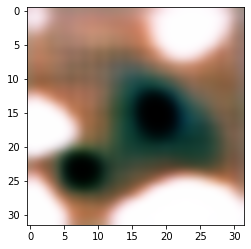

[0.22781408]
Progress: 99.84 %     Dloss: 18.362716674804688    err: 0.0034955746959894896     Sample time: 1.177s    _
Epoch time: 20:20s


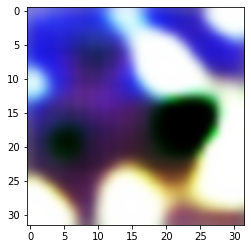

[0.3062162]
EPOCH: 2 / 2


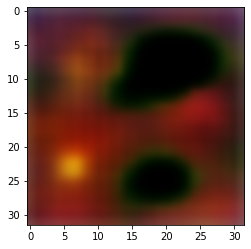

[0.5226128]
Progress: 5.23 %     Dloss: 19.63503646850586    err: 0.0038982771802693605     Sample time: 1.177s    __

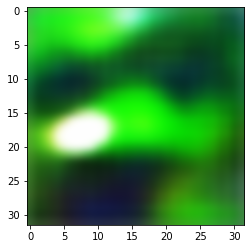

[0.05645899]
Progress: 10.56 %     Dloss: 23.204936981201172    err: 0.004813408944755793     Sample time: 1.156s    _

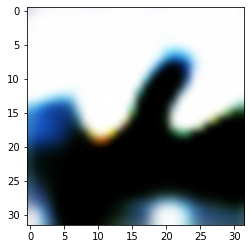

[0.42430577]
Progress: 15.89 %     Dloss: 26.489944458007812    err: 0.007770277559757233     Sample time: 1.126s    __

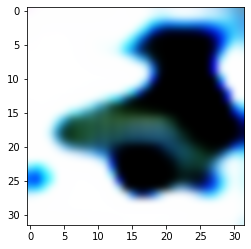

[0.0319128]
Progress: 21.23 %     Dloss: 18.876205444335938    err: 0.008197215385735035     Sample time: 1.156s    _

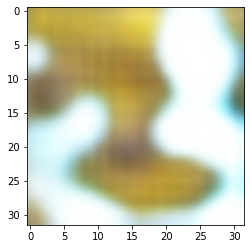

[0.70288175]
Progress: 24.11 %     Dloss: 30.90297508239746    err: 0.007099171634763479     Sample time: 1.352s    _ _

KeyboardInterrupt: 

In [19]:
epochs=2
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run()
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    gen_sample()

## # Using generator with just batch size 1 for first time is causing images to be generated extreme

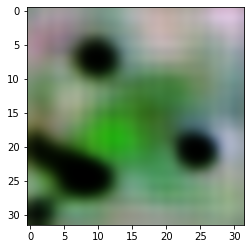

[0.06888462]


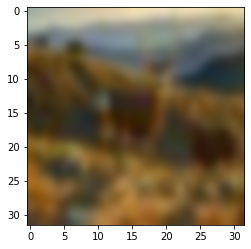

[[0.12628329]]


In [20]:
noise=np.random.randn(64,100).astype(np.float32)
gen=g.predict(noise)
gen_sample()
img=X_train[np.random.randint(low=0,high=X_train.shape[0],size=1)]
plt.imshow((img[0]+1)/2,interpolation='bicubic')
plt.show()
print(d.predict(img))

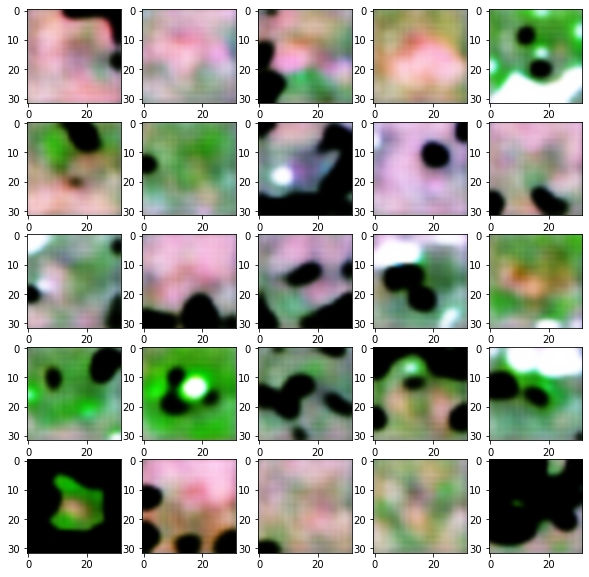

In [21]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[10,10])
fig.patch.set_facecolor('white')
noise=np.random.randn(25,100).astype(np.float32)
gen=g.predict(noise)
for i,axi in enumerate(ax.flat):
    axi.imshow((gen[i].squeeze()+1)/2,interpolation='bicubic')